In [14]:
#!pip install lifetimes

In [12]:
%matplotlib inline

In [4]:
from lifetimes.datasets import load_cdnow_summary

In [7]:
data = load_cdnow_summary(index_col=[0])
data.head(5)

## T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). 
## This is equal to the duration between a customer’s first purchase and the end of the period under study

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


### BG/NBD model - expected transaction count

In [3]:
from lifetimes import BetaGeoFitter


In [8]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [9]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


In [10]:
from lifetimes.plotting import plot_frequency_recency_matrix



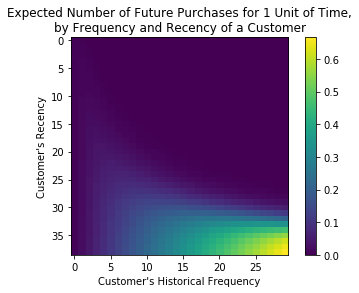

In [13]:
plot_frequency_recency_matrix(bgf)

In [15]:
from lifetimes.plotting import plot_probability_alive_matrix


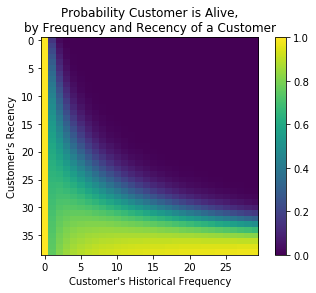

In [16]:
plot_probability_alive_matrix(bgf)

#### Ranking customers from best to worst


In [39]:
t = 2
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])


In [40]:
data.sort_values(by='predicted_purchases').tail(20)

,frequency,recency,T,predicted_purchases
ID,,,,
164,10,37.00,37.86,0.410199
485,11,33.14,36.00,0.418356
1365,9,30.57,31.71,0.421370
2220,9,25.29,27.71,0.427797
2163,8,27.57,28.00,0.428224
1712,9,28.57,30.14,0.428497
382,11,36.43,36.57,0.482453
1081,11,32.00,33.14,0.501927
1242,11,30.86,32.29,0.503937


#### Example using transactional datasets


In [18]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

In [19]:
transaction_data = load_transaction_data()


In [31]:
transaction_data.head(10)

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2
5,2014-06-08 00:00:00,2
6,2014-06-30 00:00:00,2
7,2014-07-31 00:00:00,2
8,2014-08-03 00:00:00,2
9,2014-08-06 00:00:00,3


In [ ]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

In [32]:
summary.head(10)  ### unit=day

,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0
5,1.0,77.0,251.0
6,0.0,0.0,150.0
7,1.0,1.0,316.0
8,1.0,80.0,214.0


In [28]:
summary.shape


(5000, 3)

In [22]:
from lifetimes.utils import calibration_and_holdout_data


In [33]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )

In [34]:
summary_cal_holdout.head(10)

### perform fitting on the _cal columns, and test on the _holdout columns
### 298=177+121

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
0,0.0,0.0,177.0,0.0,121
1,0.0,0.0,103.0,0.0,121
2,6.0,142.0,171.0,0.0,121
3,0.0,0.0,26.0,0.0,121
4,2.0,9.0,62.0,0.0,121
5,1.0,77.0,130.0,0.0,121
6,0.0,0.0,29.0,0.0,121
7,1.0,1.0,195.0,0.0,121
8,1.0,80.0,93.0,0.0,121


In [35]:
summary_cal_holdout.shape

(5000, 5)

In [24]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases



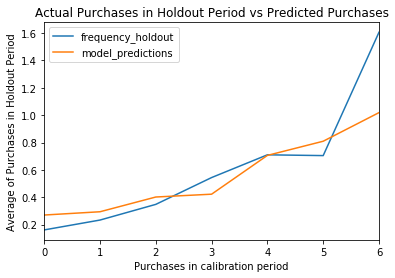

In [25]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [26]:
## customer predict

t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.05765116591827166

### Estimating customer lifetime value

In [41]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value


In [43]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()

### monetary_value is mean of a given customer’s value, not the sum
### monetary_value can be used to represent profit, or revenue, 
### or any value as long as it is consistently calculated for each customer

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


In [44]:
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]


In [45]:
returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


In [46]:
### independence assumption
### assumes that there is no relationship between the monetary value and the purchase frequency

In [47]:
returning_customers_summary[['monetary_value', 'frequency']].corr()


,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [48]:
from lifetimes import GammaGammaFitter


In [49]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [50]:
ggf

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [51]:
### average profit

cpap = ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
)

In [52]:
cpap.head(10)

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

In [53]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 35.25295817605006, Average profit: 35.07855179704017


In [54]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])


<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>

In [55]:
clv=ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

In [56]:
clv.head(5)

customer_id
1    140.096218
2     18.943466
3     38.180575
4     38.180575
5     38.180575
Name: clv, dtype: float64